In [1]:
%matplotlib inline
from IPython.display import display, Math, Latex, HTML
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
# from notebook import widgets
plt.rcParams['figure.figsize'] = (10,8)

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Показване/скриване на кода."></form>''')


Кратко описание на модела
=========================

Равновесно производство и цени:
\begin{equation}
\bar{Y}_t=(1+\bar{\gamma})\bar{Y}_{t-1}, \quad \bar{Y}_0 \text{ -- дадено}
\label{eq:cbaYbar}
\end{equation}

\begin{equation}
\bar{P}_t=(1+\bar{\pi})\bar{P}_{t-1},\quad \bar{P}_0 \text{ -- дадено}
\label{eq:cbaPbar}
\end{equation}

\begin{equation}
\bar{P}^*_t=(1+\bar{\pi}^*)\bar{P}^*_{t-1},\quad \bar{P}^*_0 \text{ -- дадено}
\label{eq:cbaPbarStar}
\end{equation}

IS връзка:
\begin{equation}
\hat{y}_t=A - a r_t + b \hat{q}_t + c \hat{g}_t + \varepsilon_{1,t}
\label{eq:cbaIS}
\end{equation} 

PC връзка (,,крива'' на Филипс):
\begin{equation}
\pi_t = \bar{\pi} + d \hat{y}_t +e \hat{q}_t + \varepsilon_{2,t}
\label{eq:cbaPC}
\end{equation}

Реален валутен курс:
\begin{equation}
\hat{q}_t = \pi^*_t - \pi_t - (\bar{\pi}^* - \bar{\pi})
\label{eq:cbaRER}
\end{equation}

Реални лихвени проценти:
\begin{equation}
r_t \approx i_t - \pi_t 
\label{eq:cbaRealIntRate}
\end{equation}

\begin{equation}
r_t^* \approx i_t^* - \pi_t^*
\label{eq:cbaRealIntRateStar}
\end{equation} 

Номинален лихвен процент (с рискова премия):
\begin{equation}
i_t = i^*_t + f \hat{g}_t 
\label{eq:cbaNomIntRate}
\end{equation}

Баланс на управление ,,Емисионно'':
\begin{equation}
F_t = M_t+ \Gamma_t 
\label{eq:cbaIntRes}
\end{equation}

Уравнение, включващо скоростта на парично обращение:
\begin{equation}
M_t V = P_t Y_t
\label{eq:cbaMonVel}
\end{equation}

In [2]:
# Parameters / Параметри
rbar = 0.05
a = 1
b = 0.5
c = 1
d = 1.1
e = 1
f = 0.8
pistarbar = 0.02
gammabar = 0.03
phi = 0.10
tau = 0.35

M_init = 12500
Gamma_init = 10000

# Derived quantitites
A = a*rbar
pibar = pistarbar
F_init = M_init + Gamma_init
Mshare = M_init/F_init

# Exogenous variables and shocks / Екзогенни променливи и шокове
eps1 = 0
eps2 = 0
ghat = 0
rstar = A/a
pistar = pistarbar

# Function definitions / Дефиниции на съответните функции
def ISline(r_in, apar, bpar, cpar, qhat_in=0, ghat_in=0, eps1_in=0):
    yhat_out = (A - apar*r_in + bpar*qhat_in + cpar*ghat_in + eps1_in)
    return yhat_out

def PCline(dpar, epar, yhat_in=0, qhat_in=0, eps2_in=0):
    pi_out = (pibar + dpar*yhat_in + epar*qhat_in + eps2_in)
    return pi_out

def yhatfinal(rstar_in=rstar, Apar=A, apar=a, bpar=b, cpar=c, dpar=d, epar=e, fpar=f, 
              pistar_in=pistarbar, ghat_in=0, eps1_in=0, eps2_in=0):
    yhat_out = ((1+epar)/(1+epar-dpar*(apar-bpar))*(Apar-apar*rstar_in) + 
        ((1+epar)*(cpar-apar*fpar))/(1+epar-dpar*(apar-bpar))*ghat_in + 
        (bpar-apar)/(1+epar-dpar*(apar-bpar))*(pistar_in-pistarbar) + 
        ((1+epar)*apar)/(1+epar-dpar*(apar-bpar))*(pibar-pistarbar) + 
        (1+epar)/(1+epar-dpar*(apar-bpar))*eps1_in + 
        (apar-bpar)/(1+epar-dpar*(apar-bpar))*eps2_in )
    return yhat_out

def pifinal(rstar_in=rstar, Apar=A, apar=a, bpar=b, cpar=c, dpar=d, epar=e, fpar=f, pistar_in=pistarbar, ghat_in=0, eps1_in=0, eps2_in=0):
    pi_out = ((1+epar+dpar*bpar)/(1+epar-dpar*(apar-bpar))*pibar + 
      dpar/(1+epar-dpar*(apar-bpar))*(Apar-apar*rstar_in) + 
      (dpar*(cpar-apar*fpar))/(1+epar-dpar*(apar-bpar))*ghat_in + 
      (epar-dpar*(apar-bpar))/(1+epar-dpar*(apar-bpar))*pistar_in - 
      (dpar*bpar+epar)/(1+epar-dpar*(apar-bpar))*pistarbar + 
      dpar/(1+epar-dpar*(apar-bpar))*eps1_in + 
      1/(1+epar-dpar*(apar-bpar))*eps2_in )
    return pi_out

def ComputeDelta(phipar, gammabarpar, pibarpar):
    return phipar/((1+pibarpar)*(1+gammabarpar))*((1+pibarpar)*(1+gammabarpar)-1)

def Mchange(infl,yht,gammabarpar):
    return (1+infl)*(1+yht)*(1+gammabarpar)-1

def Gammachange(infl,yht,ght,gammabarpar,phipar,taupar,pibarpar):
    deltapar = ComputeDelta(phipar,gammabarpar,pibarpar)
    return ((1+infl)*(1+gammabarpar))/phipar*( taupar*(1+yht)-(taupar-deltapar)*(1+ght) )

def Fchange(Mch,Gch,Mshare):
    return Mshare*Mch + (1-Mshare)*Gch

In [3]:
yhat = yhatfinal(rstar)

Pi = pifinal(rstar)

yhat_vec = np.array([-0.06,0.06]) 
Pi_vec = PCline(d,e,yhat_vec,0,eps2)
rstar_vec = np.array([-0.01,0.12])
r_vec = rstar_vec
pi_vec = pifinal(rstar_vec)


Свойства на IS връзката
=======================

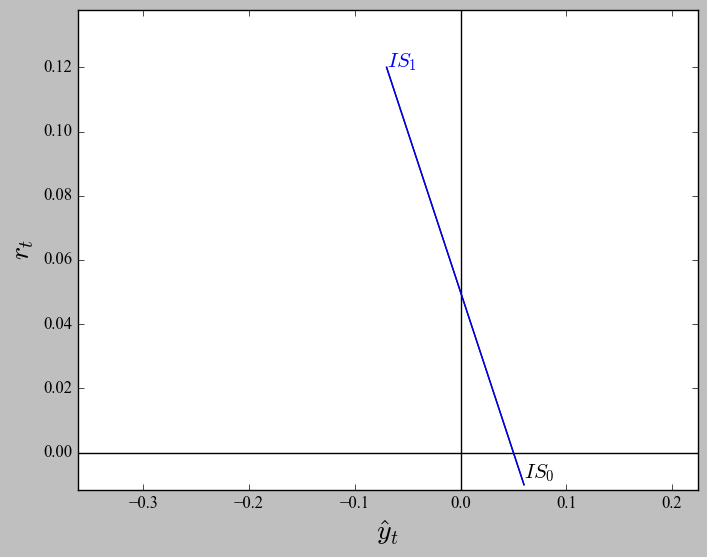

In [4]:
qht_min = -0.05
qht_max = 0.05
ght_min = -0.05
ght_max = 0.05
e1_min = -0.05
e1_max = 0.05
ap_min = 0.0
ap_max = 2.0
def displayISline(rr,qht,ght,e1,ap):
    yht_0 = ISline(rr,a,b,c,0,0,0)
    yht = ISline(rr,ap,b,c,qht,ght,e1)
    plt.plot(yht_0,rr,'k-')
    plt.plot(yht,rr)
    xmin = min(ISline(rr,ap_max,b,c,qht_min,ght_min,e1_min))
    xmax = max(ISline(rr,ap_max,b,c,qht_max,ght_max,e1_max))
    xl = xmin*1.15 if xmin<=0 else xmin*0.85
    xu = xmax*0.85 if xmax<=0 else xmax*1.15
    
    if min(rr)<0:
        yl = min(rr)*1.15
    elif min(rr)>0:
        yl = min(rr)*0.85
    else: 
        yl = -0.01    
    
    if max(rr)<0:
        yu = max(rr)*0.85
    elif max(rr)>0:
        yu = max(rr)*1.15
    else: 
        yu = 0.01   
    
    plt.xlim([xl,xu])
    plt.ylim([yl,yu])
    plt.hlines(0, xl, xu)
    plt.vlines(0, yl, yu)
    plt.xlabel('$\hat{y}_t$',fontsize=20)
    plt.ylabel('$r_t$',fontsize=20)
    plt.text(yht_0[0],rr[0]+0.002,"$IS_0$",fontsize=15)
    plt.text(yht[-1],rr[-1],"$IS_1$",fontsize=15,color="blue")
    
wIS = interactive(displayISline,
                rr = fixed(r_vec),
                qht = widgets.FloatSlider(min=qht_min,max=qht_max,step=0.01,description="$\hat{q}_t$",continuous_update=False), 
                ght = widgets.FloatSlider(min=ght_min,max=ght_max,step=0.01,description="$\hat{g}_t$",continuous_update=False), 
                e1 = widgets.FloatSlider(min=e1_min,max=e1_max,step=0.01,description="$\epsilon_{1,t}$",continuous_update=False),
                ap = widgets.FloatSlider(min=ap_min,max=ap_max,step=0.1,value=a,description="$a$",continuous_update=False))
display(wIS)

Свойства на PC връзката
=======================

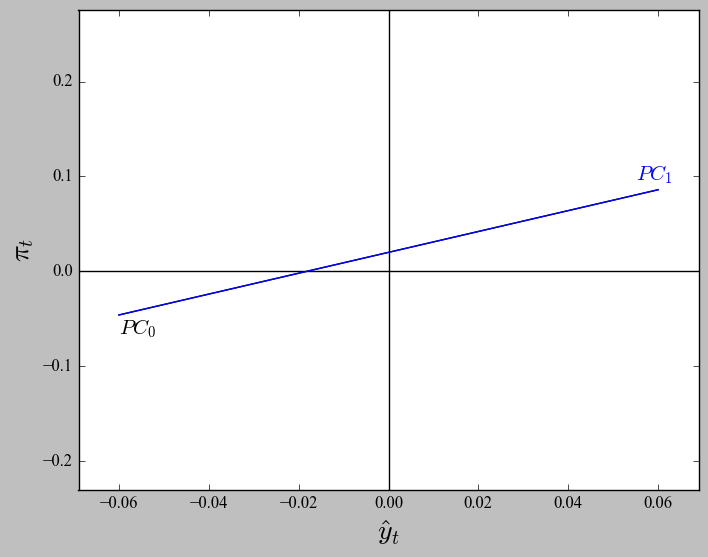

In [5]:
qht_min = -0.05
qht_max = 0.05
e2_min = -0.05
e2_max = 0.05
dp_min = 0.0
dp_max = 2.0
def displayPCline(yht,qht,e2,dp):
    infl_0 = PCline(d,e,yht,0,0)
    infl = PCline(dp,e,yht,qht,e2)
    plt.plot(yht,infl_0,'k-')
    plt.plot(yht,infl)
    
    if min(yht)<0:
        xl = min(yht)*1.15
    elif min(yht)>0:
        xl = min(yht)*0.85 
    else: 
        xl = -0.01    
    
    if max(yht)<0:
        xu = max(yht)*0.85
    elif max(yht)>0:
        xu = max(yht)*1.15
    else: 
        xu = 0.01   
    
    ymin = min(PCline(dp_max,e,yht,qht_min,e2_min))
    ymax = max(PCline(dp_max,e,yht,qht_max,e2_max))
    yl = ymin*1.15 if ymin<=0 else ymin*0.85
    yu = ymax*0.85 if ymax<=0 else ymax*1.15
    plt.xlim([xl,xu])
    plt.ylim([yl,yu])
    plt.hlines(0, xl, xu)
    plt.vlines(0, yl, yu)
    plt.xlabel('$\hat{y}_t$',fontsize=20)
    plt.ylabel('$\pi_t$',fontsize=20)
    plt.text(yht[0],infl_0[0]-0.02,"$PC_0$",fontsize=15)
    plt.text(yht[-1]-0.005,infl[-1]+0.01,"$PC_1$",fontsize=15,color="blue")

wPC = interactive(displayPCline, 
                yht = fixed(yhat_vec),
                qht = widgets.FloatSlider(min=qht_min,max=qht_max,step=0.01,description="$\hat{q}_t$",continuous_update=False),
                e2 = widgets.FloatSlider(min=e2_min,max=e2_max,step=0.01,description="$\epsilon_{2,t}$",continuous_update=False),
                dp = widgets.FloatSlider(min=dp_min,max=dp_max,step=0.1,value=d, description="$d$",continuous_update=False))
display(wPC)

Решение на модела
=================

При зададените стойности на параметрите, шоковете и екзогенните променливи инфлацията е 2.0%.
Отклонението от потенциалното производство е 0.0%.
Изменението на резервните пари е 5.1%.
Изменението на депозита на правителството в централната банка е 5.1%.
Изменението на валутните резерви е 5.1%.


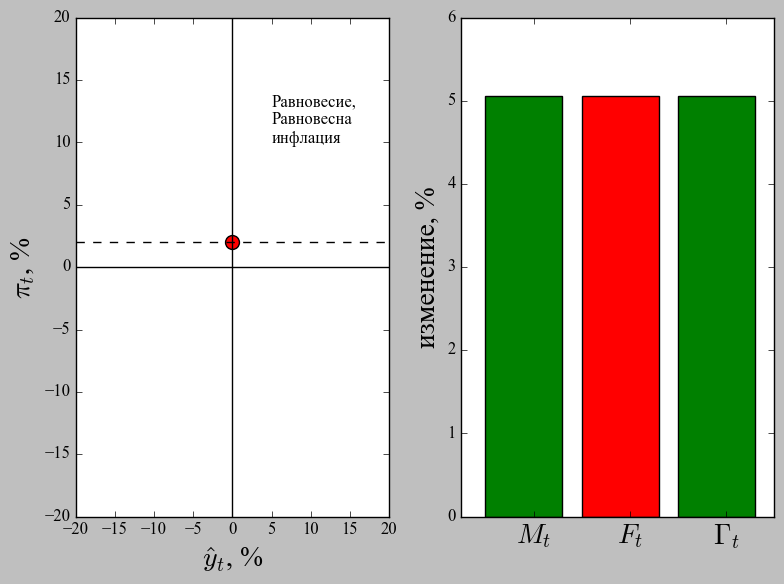

In [6]:
plt.rcdefaults()
plt.rcParams['font.family'] = 'fantasy'
plt.rcParams['font.fantasy'] = 'Times New Roman', 'Ubuntu','Arial','Tahoma','Calibri'

rstar_min = -0.05
rstar_max = 0.10
pistar_min = -0.05
pistar_max = 0.10
ghat_min = -0.05
ghat_max = 0.05
eps1_min = -0.05
eps1_max = 0.05
eps2_min = -0.05
eps2_max = 0.05
Ap_min = 0.0
Ap_max = 2.0
ap_min = 0.0
ap_max = 2.0
bp_min = 0.0
bp_max = 2.0
cp_min = 0.0
cp_max = 2.0
dp_min = 0.0
dp_max = 2.0
ep_min = 0.0
ep_max = 2.0
fp_min = 0.0
fp_max = 2.0
phip_min = 0.05
phip_max = 0.3
taup_min = 0.30
taup_max = 0.45
gammabp_min = 0.0
gammabp_max = 0.04

def printmainvars(Apar=A, apar=a, bpar=b, cpar=c, dpar=d, epar=e, fpar=f, gammabarpar=gammabar, 
                  rstar_in=rstar, pistar_in=pistarbar, ghat_in=0, eps1_in=0, eps2_in=0,
                  phipar=phi, taupar=tau, Mshpar=Mshare):
    yhatsol = yhatfinal(rstar_in, Apar, apar, bpar, cpar, dpar, epar, fpar, pistar_in, ghat_in, eps1_in, eps2_in)
    pisol = pifinal(rstar_in, Apar, apar, bpar, cpar, dpar, epar, fpar, pistar_in, ghat_in, eps1_in, eps2_in)
    pisol = round(pisol,3)
    yhatsol = round(yhatsol,3)
    Mchsol = Mchange(pisol,yhatsol,gammabarpar)
    Gammachsol = Gammachange(pisol,yhatsol,ghat_in,gammabarpar,phipar,taupar,pibar) 
    Fchsol = Fchange(Mchsol,Gammachsol,Mshpar)
    print("При зададените стойности на параметрите, шоковете и екзогенните променливи инфлацията е {:0.1f}%.".format(pisol*100))
    print("Отклонението от потенциалното производство е {:0.1f}%.".format(yhatsol*100))
    print("Изменението на резервните пари е {:0.1f}%.".format(Mchsol*100))
    print("Изменението на депозита на правителството в централната банка е {:0.1f}%.".format(Gammachsol*100))
    print("Изменението на валутните резерви е {:0.1f}%.".format(Fchsol*100))
    
    pct_multiplier = 100
    
    yhatsol*=pct_multiplier
    pisol*=pct_multiplier
    Mchsol*=pct_multiplier
    Gammachsol*=pct_multiplier
    Fchsol*=pct_multiplier
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(yhatsol,pisol,s=100,c='r')
    ax1.set_xlabel('$\hat{y}_t$, %',fontsize=20)
    ax1.set_ylabel('$\pi_t$, %',fontsize=20)
    ax1.set_xlim([-0.2*pct_multiplier,0.2*pct_multiplier])
    ax1.set_ylim([-0.2*pct_multiplier,0.2*pct_multiplier])
    ax1.hlines(0,-.2*pct_multiplier,.2*pct_multiplier)
    ax1.hlines(pibar*pct_multiplier,-.2*pct_multiplier,.2*pct_multiplier,linestyles='dashed')
    ax1.vlines(0,-.2*pct_multiplier,.2*pct_multiplier)
    
    if yhatsol<0:
        ytext = "Рецесия"
    elif yhatsol>0:
        ytext="Прегряване"
    else:
        ytext="Равновесие"
    
    if pisol==pibar*pct_multiplier:
        pitext="Равновесна\nинфлация"
    elif pisol>pibar*pct_multiplier:
        pitext="Инфлация\nнад\nравновесната"
    elif 0<pisol<pibar*pct_multiplier:
        pitext="Инфлация\nпод\nравновесната"
    elif pisol<0:
        pitext= "Дефлация"
    else:
        pitext="???"
    
    txt = ytext + ",\n" + pitext
    ax1.text(0.05*pct_multiplier,0.1*pct_multiplier, txt, size="medium")
    
    ax2.bar([1,2,3],[Mchsol,Fchsol,Gammachsol],color=['g','r','g'])
    ax2.set_xlim([0.75,4.0])
    ax2.set_ylabel('изменение, %',fontsize=20)
    ax2.set_xticks([1.5,2.5,3.5]) 
    ax2.set_xticklabels(["$M_t$", "$F_t$", "$\Gamma_t$"],fontsize=20)
    f.tight_layout() # to prevent label overlap
    
wsol = interactive(printmainvars,                      
                  Apar = widgets.BoundedFloatText(min=Ap_min,max=Ap_max,step=0.01,value=A,description="$A$"),
                  apar = widgets.BoundedFloatText(min=ap_min,max=ap_max,step=0.01,value=a,description="$a$"),
                  bpar = widgets.BoundedFloatText(min=bp_min,max=bp_max,step=0.01,value=b,description="$b$"),
                  cpar = widgets.BoundedFloatText(min=cp_min,max=cp_max,step=0.01,value=c,description="$c$"),
                  dpar = widgets.BoundedFloatText(min=dp_min,max=dp_max,step=0.01,value=d,description="$d$"),
                  epar = widgets.BoundedFloatText(min=ep_min,max=ep_max,step=0.01,value=e,description="$e$"),
                  fpar = widgets.BoundedFloatText(min=fp_min,max=fp_max,step=0.01,value=f,description="$f$"),
                  gammabarpar = widgets.BoundedFloatText(min=gammabp_min,max=gammabp_max,step=0.01,value=gammabar,description=r"$ \bar{\gamma}  $"),
                  rstar_in = widgets.FloatSlider(min=rstar_min,max=rstar_max,step=0.01,value=rstar,description="$r^*_t$"),
                  pistar_in = widgets.FloatSlider(min=pistar_min,max=pistar_max,step=0.01,value=pistar,description="$\pi^*_t$"),
                  ghat_in = widgets.FloatSlider(min=ghat_min,max=ghat_max,step=0.01,value=0,description="$\hat{g}_t$"),
                  eps1_in = widgets.FloatSlider(min=eps1_min,max=eps1_max,step=0.01,value=0,description="$\epsilon_{1,t}$"),
                  eps2_in = widgets.FloatSlider(min=eps2_min,max=eps2_max,step=0.01,value=0,description="$\epsilon_{2,t}$"),
                  phipar = widgets.FloatSlider(min=phip_min,max=phip_max,step=0.01,value=phi,description="$\phi$"),
                  taupar = widgets.FloatSlider(min=taup_min,max=taup_max,step=0.01,value=tau,description= r'$ \tau $'),
                  Mshpar = widgets.FloatSlider(min=0,max=1,step=0.01,value=Mshare,description=r'$\frac{M_{t-1}}{F_{t-1}}$'),
                  __manual=True)
wsol.children[-1].description = "Покажи"
display(wsol)